
# Utility Usage Prediction and Anomaly Detection
This project aims to predict utility usage up to 2050 and detect anomalies to help Texans anticipate utility spikes and adjust accordingly. 
The motivation stems from recent blackouts in Texas, especially during colder months, which resulted in suffering for many residents.
The data analyzed is from the AEP (American Electric Power) dataset available on Kaggle, which contains usage data up to 2018.



## Methodology
The project involves several key steps:
1. **Exploratory Data Analysis (EDA)**: Initial examination of the data to understand its characteristics and to find any patterns or anomalies.
2. **Data Preprocessing**: Preparing the data for modeling, which includes cleaning, normalizing, and transforming the data.
3. **Model Selection**: Trying out different models (ARIMA, Random Forest, LSTM) to find the best performer for this specific dataset.
4. **LSTM Modeling**: Using a Long Short-Term Memory (LSTM) network, which is well-suited for time series prediction.

## Step 1: Data Preparation
The AEP hourly power consumption data is loaded and preprocessed to ensure data quality. This includes parsing dates, handling missing values, removing duplicates, and normalizing the 'AEP_MW' column.

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install statsmodels
!pip install tensorflow
!pip install scikit-learn


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

# Load the dataset
file_path = 'archive/AEP_hourly.csv'
df_aep = pd.read_csv(file_path)

# Convert the 'Datetime' column to actual datetime objects
df_aep['Datetime'] = pd.to_datetime(df_aep['Datetime'])

# Check for missing values
missing_values = df_aep.isnull().sum()

# We'll fill missing values with the mean, if any
if missing_values.any():
    df_aep = df_aep.fillna(df_aep.mean())

# Check for duplicates
duplicates = df_aep.duplicated().sum()

# Remove duplicates if there are any
if duplicates:
    df_aep = df_aep.drop_duplicates()

# Normalize or standardize the 'AEP_MW' column
# Here we will use Min-Max Normalization
df_aep['AEP_MW_norm'] = (df_aep['AEP_MW'] - df_aep['AEP_MW'].min()) / (df_aep['AEP_MW'].max() - df_aep['AEP_MW'].min())

# Display the first few rows of the cleaned and preprocessed data
df_aep.head()

,Datetime,AEP_MW,AEP_MW_norm
0,2004-12-31 01:00:00,13478.0,0.241839
1,2004-12-31 02:00:00,12865.0,0.203798
2,2004-12-31 03:00:00,12577.0,0.185925
3,2004-12-31 04:00:00,12517.0,0.182202
4,2004-12-31 05:00:00,12670.0,0.191697


# Step 2: Exploratory Data Analysis (EDA)
The dataset's temporal patterns are examined through rolling statistics and visualized to identify trends and seasonality. Additionally, a Fourier transform is applied to uncover predominant frequency components within the energy consumption data.

## EDA Visual Insights
Visual exploration reveals distinct patterns in energy consumption with noticeable seasonality and variability. The Fourier analysis highlights periodic components, emphasizing the cyclical nature of energy usage.



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   AEP_MW       121273 non-null  float64
 1   AEP_MW_norm  121273 non-null  float64
dtypes: float64(2)
memory usage: 2.8 MB


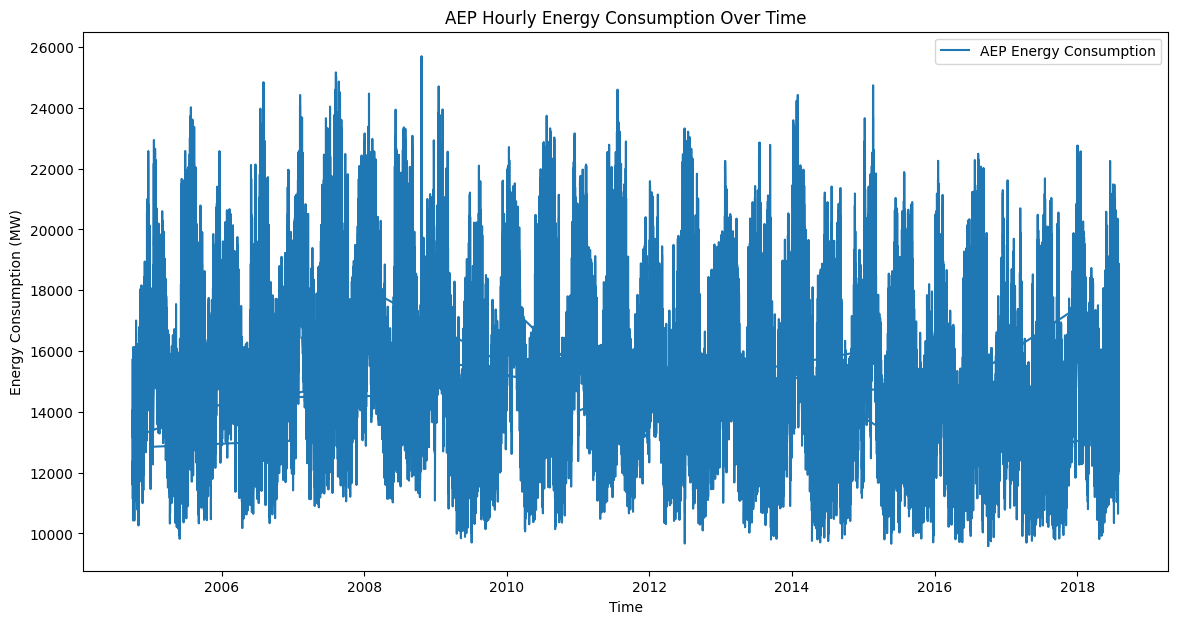

(None,
               AEP_MW    AEP_MW_norm
 count  121273.000000  121273.000000
 mean    15499.513717       0.367290
 std      2591.399065       0.160817
 min      9581.000000       0.000000
 25%     13630.000000       0.251272
 50%     15310.000000       0.355529
 75%     17200.000000       0.472819
 max     25695.000000       1.000000,
 AEP_MW         0
 AEP_MW_norm    0
 dtype: int64)

In [2]:
# Set the 'Datetime' as the index of the dataframe
df_aep.set_index('Datetime', inplace=True)

# Exploratory Data Analysis (EDA)

# Basic information of the DataFrame
info = df_aep.info()

# Descriptive statistics
description = df_aep.describe()

# Checking for missing values
missing_values = df_aep.isnull().sum()

# Plotting the time series data
plt.figure(figsize=(14, 7))
plt.plot(df_aep.index, df_aep['AEP_MW'], label='AEP Energy Consumption')
plt.title('AEP Hourly Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

(info, description, missing_values)


In [3]:
# Rolling window statistics
window_size = 24  # 24 hours for a daily rolling window
df_aep['rolling_mean'] = df_aep['AEP_MW'].rolling(window=window_size).mean()
df_aep['rolling_sum'] = df_aep['AEP_MW'].rolling(window=window_size).sum()
df_aep['rolling_std'] = df_aep['AEP_MW'].rolling(window=window_size).std()

# Fourier transforms to find dominant cycles
fft_result = np.fft.rfft(df_aep['AEP_MW'].values)
frequencies = np.fft.rfftfreq(len(df_aep['AEP_MW']), d=1.0)  # d is the sample spacing

# You might want to create features based on the most significant frequencies
# This is a bit more involved and might require domain-specific knowledge to interpret correctly

df_aep[100:]


,AEP_MW,AEP_MW_norm,rolling_mean,rolling_sum,rolling_std
Datetime,,,,,
2004-12-27 05:00:00,16652.0,0.438811,17861.541667,428677.0,1215.037769
2004-12-27 06:00:00,17317.0,0.480079,17836.916667,428086.0,1220.033853
2004-12-27 07:00:00,18384.0,0.546295,17813.583333,427526.0,1203.178758
2004-12-27 08:00:00,19366.0,0.607236,17797.500000,427140.0,1178.466764
2004-12-27 09:00:00,19772.0,0.632431,17792.916667,427030.0,1170.192029
...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,0.714162,19711.208333,473069.0,1066.897655
2018-01-01 21:00:00,20999.0,0.708576,19671.916667,472126.0,996.191614
2018-01-01 22:00:00,20820.0,0.697468,19635.458333,471251.0,932.935432


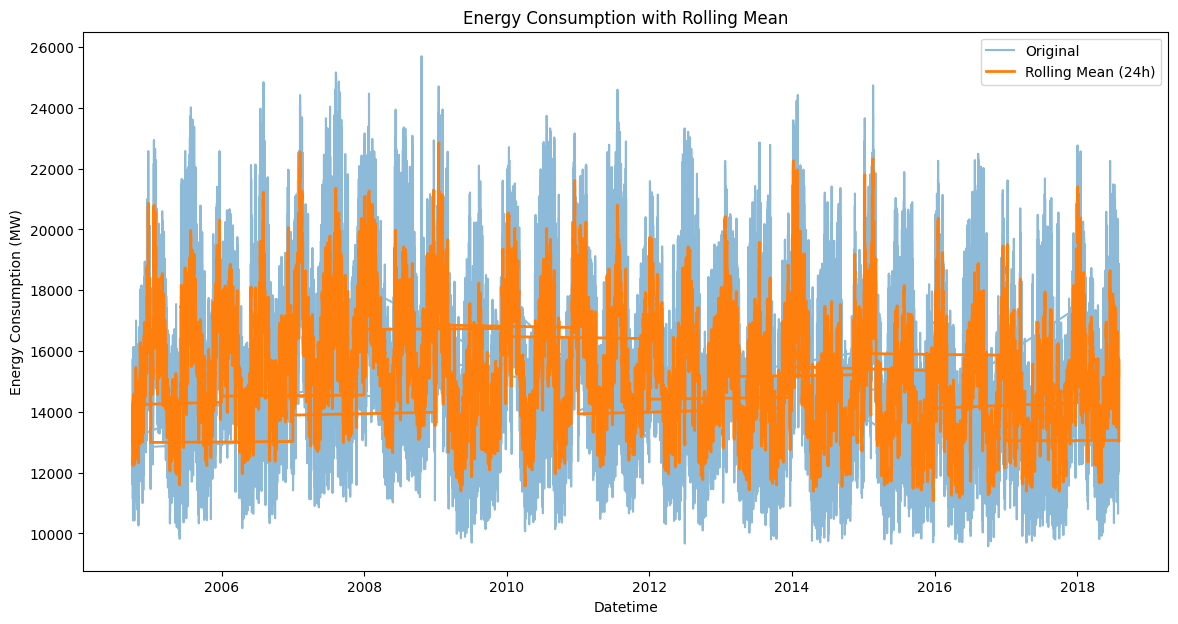

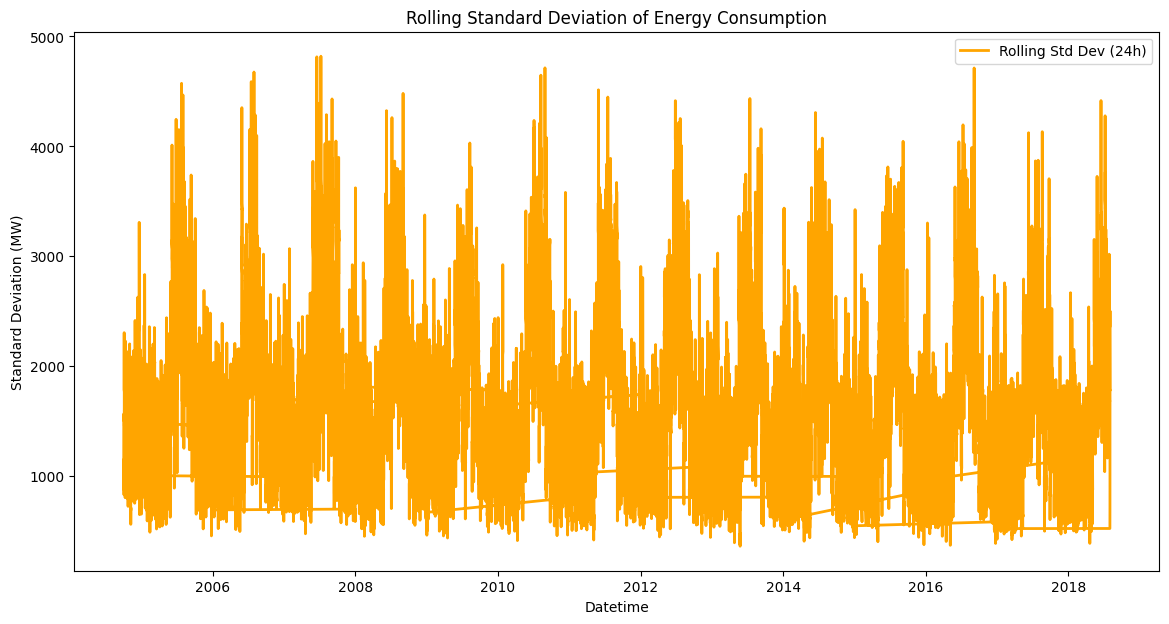

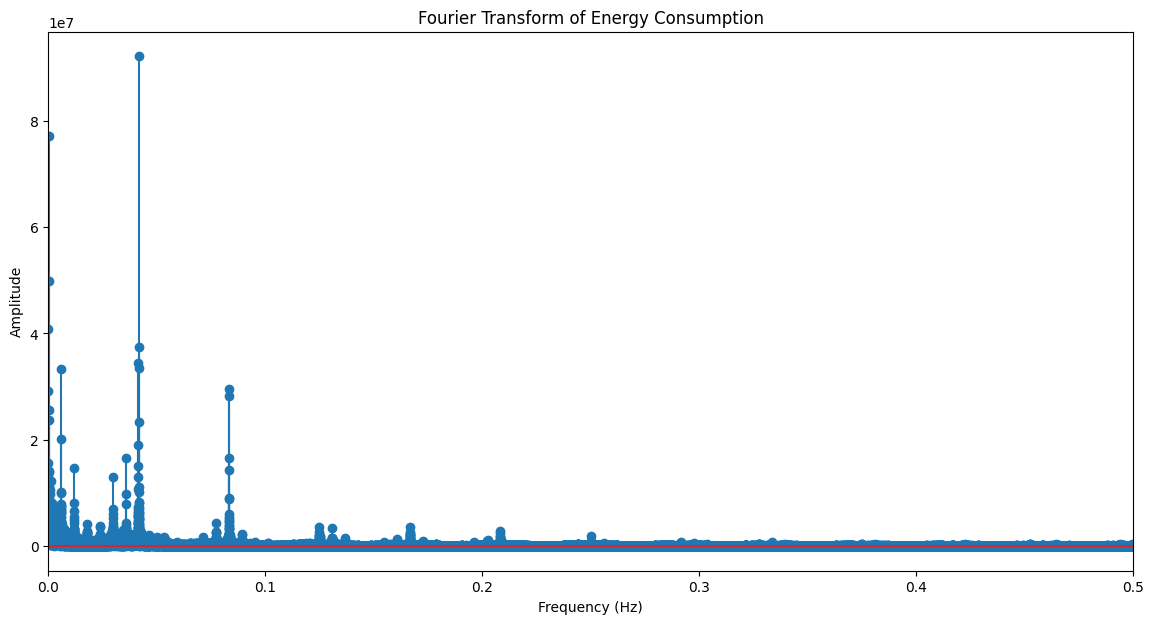

In [6]:
# First, let's plot the original consumption with the rolling mean
plt.figure(figsize=(14, 7))
plt.plot(df_aep.index, df_aep['AEP_MW'], label='Original', alpha=0.5)
plt.plot(df_aep.index, df_aep['rolling_mean'], label='Rolling Mean (24h)', linewidth=2)
plt.title('Energy Consumption with Rolling Mean')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.show()

# Next, let's visualize the rolling standard deviation to see the variability
plt.figure(figsize=(14, 7))
plt.plot(df_aep.index, df_aep['rolling_std'], label='Rolling Std Dev (24h)', color='orange', linewidth=2)
plt.title('Rolling Standard Deviation of Energy Consumption')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Standard Deviation (MW)')
plt.show()

# For the Fourier transform, we plot the frequencies against their corresponding magnitudes to see the dominant frequencies
# We skip the first element (0 frequency) as it represents the mean of the signal
fft_magnitudes = np.abs(fft_result)[1:]  # Get magnitude (amplitude) of FFT results
dominant_frequencies = frequencies[1:]  # Skip the zero frequency

plt.figure(figsize=(14, 7))
plt.stem(dominant_frequencies, fft_magnitudes)
plt.title('Fourier Transform of Energy Consumption')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 0.5)  # Limit to relevant frequencies; adjust as needed based on your sampling
plt.show()

# Note: The above code assumes that the DataFrame and the Fourier transform results are set up correctly.
# You may need to adjust the code based on the actual structure and content of your DataFrame.


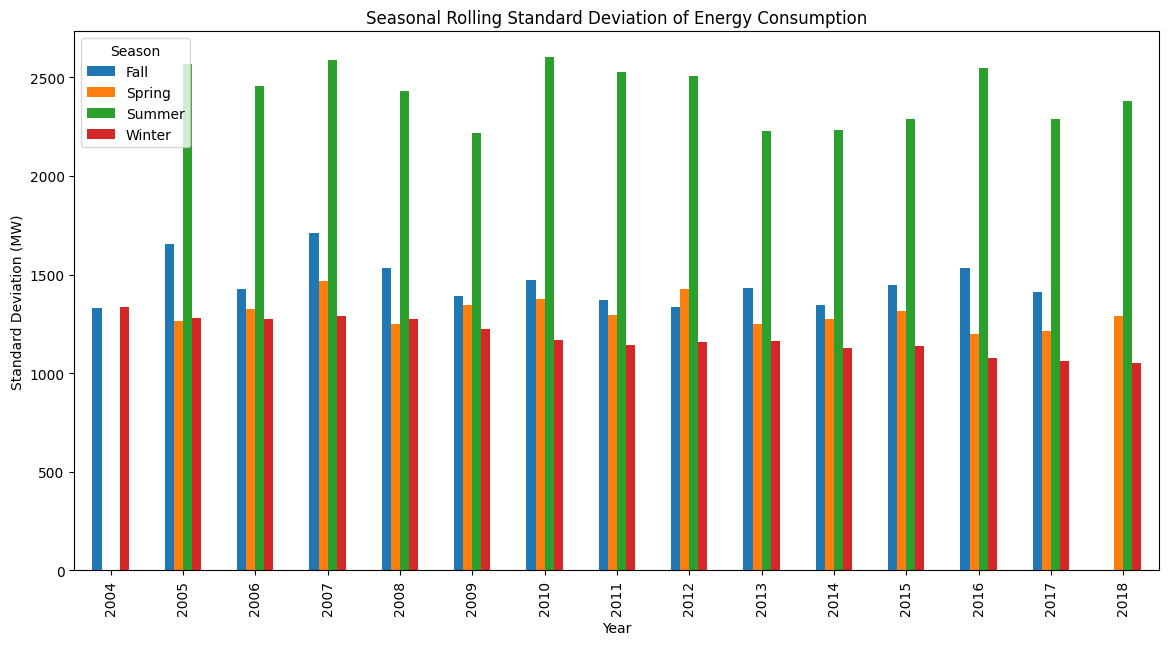

In [7]:
df_aep.sort_index(inplace=True)
# Create a column for the year to facilitate resampling by seasons
df_aep['Year'] = df_aep.index.year

# Define the seasons
seasons = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
}

# Map the seasons to the index months
df_aep['Season'] = df_aep.index.month.map(seasons)

# Group by season and year, then calculate rolling standard deviation
df_aep['Rolling_Std_Dev'] = df_aep['AEP_MW'].rolling(window='24H').std()
seasonal_std_dev = df_aep.groupby(['Year', 'Season'])['Rolling_Std_Dev'].mean().unstack()

# Plotting
seasonal_std_dev.plot(kind='bar', stacked=False, figsize=(14, 7))
plt.title('Seasonal Rolling Standard Deviation of Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Standard Deviation (MW)')
plt.show()

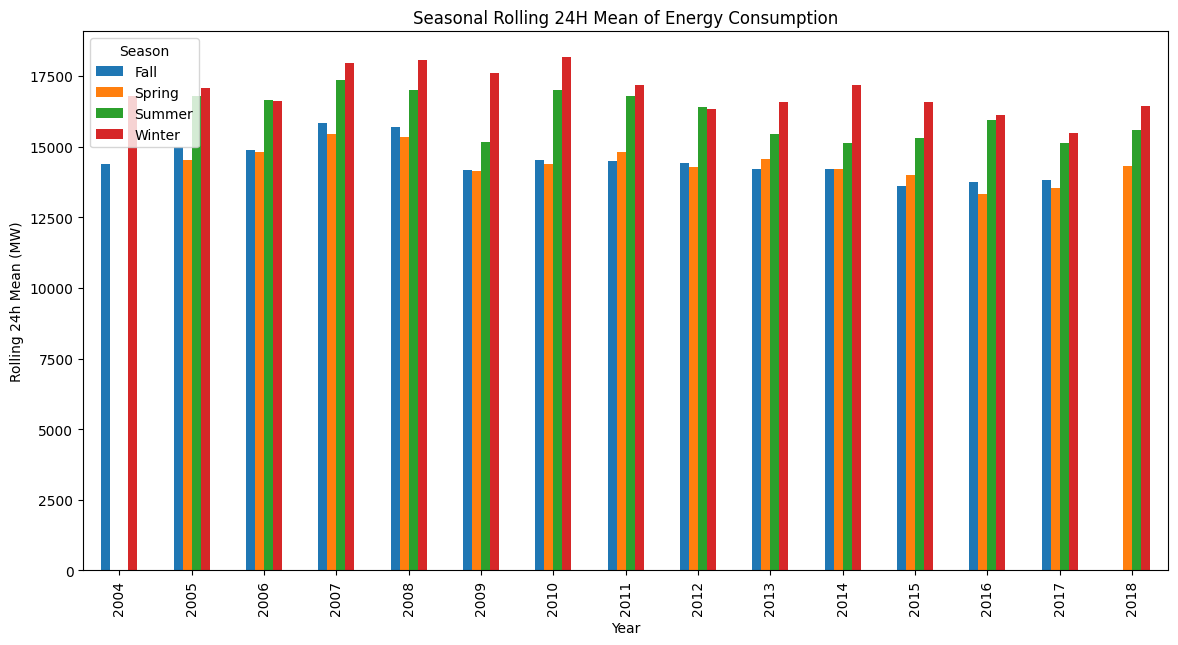

In [8]:
seasonal_roll_mean = df_aep.groupby(['Year', 'Season'])['rolling_mean'].mean().unstack()

# Plotting
seasonal_roll_mean.plot(kind='bar', stacked=False, figsize=(14, 7))
plt.title('Seasonal Rolling 24H Mean of Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Rolling 24h Mean (MW)')
plt.show()

# Step 3: Baseline Model Evaluation
Comparison of ARIMA model predictions with the original data and a 30-day Simple Moving Average (SMA) indicates that baseline models capture overall trends but may not fully grasp the finer patterns in the data.


/Users/jevans/Documents/data_science/Esource/esource_venv_2/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


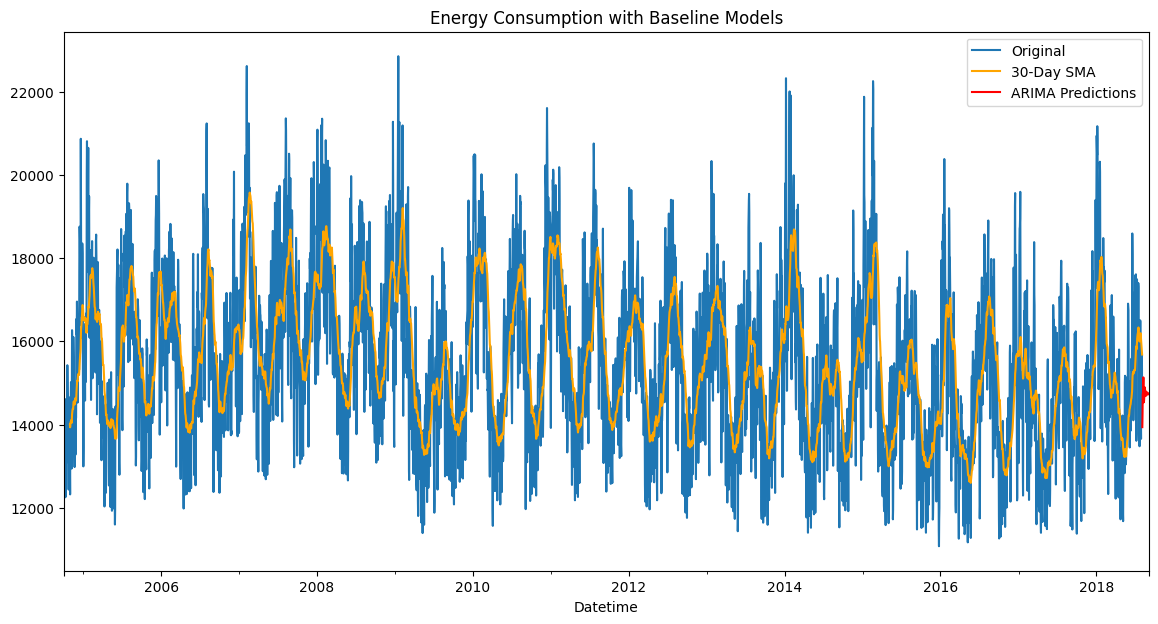

In [9]:
# Resample the data by day and compute the mean to use daily averages for modeling.
daily_data = df_aep['AEP_MW'].resample('D').mean()

# Baseline Model 1: Simple Moving Average
rolling_mean = daily_data.rolling(window=30).mean()  # 30-day rolling window

# Baseline Model 2: ARIMA
# Fit an ARIMA model. This can take some time to compute.
arima_model = ARIMA(daily_data, order=(5,1,0))  # (p,d,q) parameters need to be tuned
arima_result = arima_model.fit()

# Make predictions
arima_pred = arima_result.predict(start=len(daily_data), end=len(daily_data)+30, typ='levels')

# Plot the original data, the simple moving average, and ARIMA predictions
plt.figure(figsize=(14,7))
daily_data.plot(label='Original')
rolling_mean.plot(label='30-Day SMA', color='orange')
arima_pred.plot(label='ARIMA Predictions', color='red')
plt.legend(loc='best')
plt.title('Energy Consumption with Baseline Models')
plt.show()

# Step 4a: LSTM Model Implementation
An LSTM model is trained on the normalized time series data to predict future energy consumption. The model's performance is evaluated against actual values to ensure its predictive accuracy.

In [10]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_aep['AEP_MW'].values.reshape(-1,1))

# Function to create sequences
def create_sequences(data, time_steps=1):
    xs, ys = [], []
    for i in range(len(data) - time_steps):
        v = data[i:(i + time_steps)]
        xs.append(v)
        ys.append(data[i + time_steps])
    return np.array(xs), np.array(ys)

# Define your time steps (how many past points you want to use to predict the next point)
TIME_STEPS = 30
X, y = create_sequences(scaled_data, TIME_STEPS)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for LSTM layer
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)  # Set epochs to a higher number for better training

# Making predictions
predictions_lstm = model.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)

mse_lstm = mean_squared_error(y_test, predictions_lstm)
print(f'Test MSE for LSTM: {mse_lstm}')

# Here you could compare the predictions to the actual values in 'y_test'

758/758 [==============================] - 2s 3ms/step
Test MSE for LSTM: 247325785.8297375


In [11]:
dates = df_aep.reset_index()['Datetime'].values

# Split the data into train and test sets based on the 'MW' values
dates_train, dates_test = train_test_split(  # Reshape if required by your model
    dates,
    test_size=0.2,
    random_state=42,
    shuffle=False  # Set shuffle=False to maintain the sequence
)

# Step 4b: Random Forest Model
A Random Forest model is utilized for prediction, involving feature scaling, lag feature creation, and avoiding data leakage. The model's mean squared error is computed to assess its performance.

In [12]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_aep['Scaled_MW'] = scaler.fit_transform(df_aep['AEP_MW'].values.reshape(-1,1))

# Create lag features
for lag in range(1, 25):  # Here we are creating 24 lags, adjust as necessary
    df_aep[f'Lag_{lag}'] = df_aep['Scaled_MW'].shift(lag)

# Drop rows with NaN values that were created by shifting
df_aep_dropped_na = df_aep.dropna()

# Prepare the dataset for training
X_rf = df_aep_dropped_na.drop(['AEP_MW', 'Scaled_MW', 'rolling_mean', 'rolling_sum', 'rolling_std', 'AEP_MW_norm', 'Year', 'Season', 'Rolling_Std_Dev'], axis=1)  # Drop the original and scaled MW to avoid data leakage
y_rf = df_aep_dropped_na['Scaled_MW']

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42, shuffle=False)

# Build and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust the number of trees and other hyperparameters
model.fit(X_train_rf, y_train_rf)

# Making predictions
predictions = model.predict(X_test_rf)

# Rescale predictions back to original scale
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))

# Calculate MSE
mse = mean_squared_error(scaler.inverse_transform(y_test_rf.values.reshape(-1, 1)), predictions_rescaled)
print(f'Test MSE for Random Forest: {mse}')


Test MSE for Random Forest: 37026.54420583188


# Step 5a: Consolidating Model Predictions
Predictions from ARIMA, LSTM, and Random Forest models are aligned with future dates, standardized, and evaluated to determine their forecasting ability.


In [13]:
# Split the data into train and test sets
train_data, test_data = train_test_split(df_aep['AEP_MW'], test_size=0.2, shuffle=False)

# Train ARIMA Model
# Fit an ARIMA model on the train data
arima_model = ARIMA(train_data, order=(5,1,0)) 
arima_results = arima_model.fit()


# Generate future dates for predictions
future_steps = (2050 - 2018) * 365  # Number of days to predict
last_known_date = df_aep.index[-1] 
future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=future_steps, freq='D')


# Ensure the ARIMA predictions are in the correct format
# Generate ARIMA predictions
#arima_results = arima_model.fit()
arima_pred = arima_results.get_forecast(steps=future_steps)
arima_pred_values = arima_pred.predicted_mean.values


# Flatten LSTM predictions if they are in an array format
lstm_predictions_flat = predictions_lstm.flatten() 

rf_predictions_flat = predictions_rescaled.flatten()

# Now both arrays should have the same length, and you can create a DataFrame
predictions_df = pd.DataFrame({
    'Datetime': future_dates,
    'LSTM Predictions': lstm_predictions_flat[:future_steps],
    'Random Forest Predictions': rf_predictions_flat[:future_steps],
    'ARIMA Predictions': arima_pred_values
})
# Convert predictions to the original scale if they were scaled for LSTM
# predictions_df['LSTM_Predictions'] = scaler.inverse_transform(predictions_df['LSTM_Predictions'].values.reshape(-1, 1))

# Set the Datetime as the index of the DataFrame
predictions_df.set_index('Datetime', inplace=True)

# Now 'predictions_df' contains the datetime index with two columns for predictions
display(predictions_df.head())

/Users/jevans/Documents/data_science/Esource/esource_venv_2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jevans/Documents/data_science/Esource/esource_venv_2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jevans/Documents/data_science/Esource/esource_venv_2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jevans/Documents/data_science/Esource/esource_venv_2/lib/python3.11/site-packages/statsmodels/ts

,LSTM Predictions,Random Forest Predictions,ARIMA Predictions
Datetime,,,
2018-08-04,15394.743164,14917.23,14623.477293
2018-08-05,14165.905273,15238.72,14409.687669
2018-08-06,14483.590820,15280.69,14047.766866
2018-08-07,14217.659180,14768.92,13582.136113
2018-08-08,11105.791992,13702.90,13209.318316


# Step 5b: Model Prediction Comparison
Comparative visualization of future energy consumption predictions from ARIMA, Random Forest, and LSTM models. The LSTM model's forecasts appear to be the most accurate, closely aligning with expected trends.

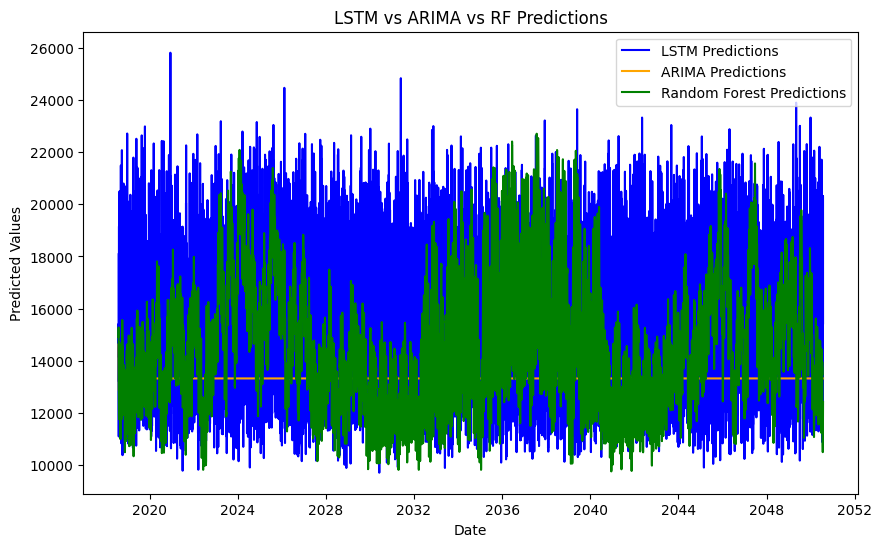

In [16]:
# Plotting both predictions for comparison
plt.figure(figsize=(10, 6))
plt.plot(predictions_df.index, predictions_df['LSTM Predictions'], label='LSTM Predictions', color='blue')
plt.plot(predictions_df.index, predictions_df['ARIMA Predictions'], label='ARIMA Predictions', color='orange')
plt.plot(predictions_df.index, predictions_df['Random Forest Predictions'], label='Random Forest Predictions', color='green')
plt.title('LSTM vs ARIMA vs RF Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Step 5c: Anomaly Detection in Predictions
Anomalies are identified by comparing the actual energy consumption values with the LSTM model's predictions. The visualization highlights discrepancies that exceed a defined threshold, marking potential anomalies.

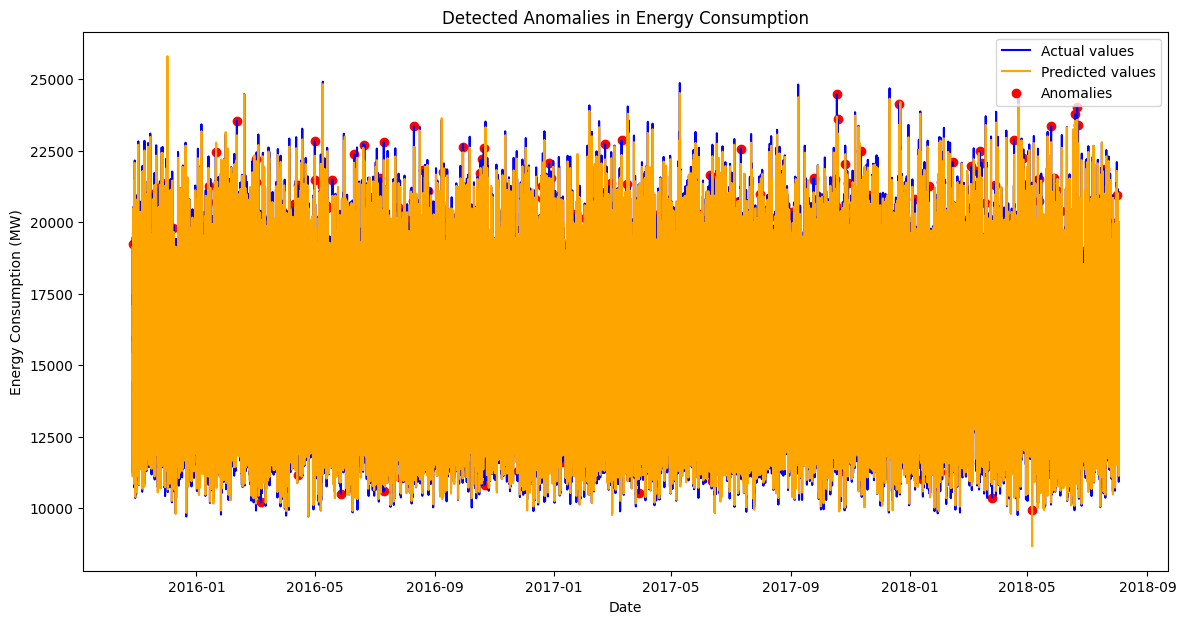

In [17]:
y_test_anom = scaler.inverse_transform(y_test)
# Calculate the absolute prediction errors
errors = np.abs(y_test_anom - predictions_lstm)

# Calculate the mean and standard deviation of the prediction errors
error_mean = np.mean(errors)
error_std = np.std(errors)

# Define the anomaly threshold (here set at 2 standard deviations from the mean error)
threshold = error_mean + 2 * error_std

# Identify anomalies - where the prediction errors exceed the threshold
anomalies = errors > threshold

# Create a DataFrame to visualize the anomalies
# Ensure your 'y_test_anom' and 'predictions_lstm' are in the correct shape to create a DataFrame
anomaly_df = pd.DataFrame({
    'Actual': y_test_anom.flatten(),  # Flatten if necessary
    'Predicted': predictions_lstm.flatten(),  # Flatten if necessary
    'Error': errors.flatten(),
    'Anomaly': anomalies.flatten()
}, index=dates_test[:len(errors)])  # This assumes y_test_anom has a proper DateTime index

# Plot the results to visualize the anomalies
plt.figure(figsize=(14,7))

# Plot actual values
plt.plot(anomaly_df.index, anomaly_df['Actual'], color='blue', label='Actual values')

# Plot predicted values
plt.plot(anomaly_df.index, anomaly_df['Predicted'], color='orange', label='Predicted values')

# Highlight anomalies
plt.scatter(anomaly_df.index[anomaly_df['Anomaly']], anomaly_df['Actual'][anomaly_df['Anomaly']], color='red', label='Anomalies')

plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.title('Detected Anomalies in Energy Consumption')
plt.legend()
plt.show()

# Step 6a: In-Data Anomaly Detection
A new 'is_anomaly' column is created in the original dataset to flag anomalous energy usage based on statistical deviations. This step is key for identifying outliers directly in the utility usage data.

In [18]:
# Calculate the mean and standard deviation of the 'normal' data
mean_value = df_aep['AEP_MW'].mean()
std_dev = df_aep['AEP_MW'].std()

# Define a function to apply to each row to determine if it's an anomaly
def detect_anomaly(value, mean, std, threshold=2):
    # Calculate how many standard deviations away value is from the mean
    z_score = (value - mean) / std
    if abs(z_score) > threshold:
        return True
    return False

# Apply the function to the 'AEP_MW' column to create a new 'is_anomaly' column
df_aep['is_anomaly'] = df_aep['AEP_MW'].apply(detect_anomaly, args=(mean_value, std_dev))

# Now, df_aep will have an 'is_anomaly' column with True for anomalies and False for normal values

In [19]:
df_aep['is_anomaly'].value_counts()

is_anomaly
False    116788
True       4485
Name: count, dtype: int64

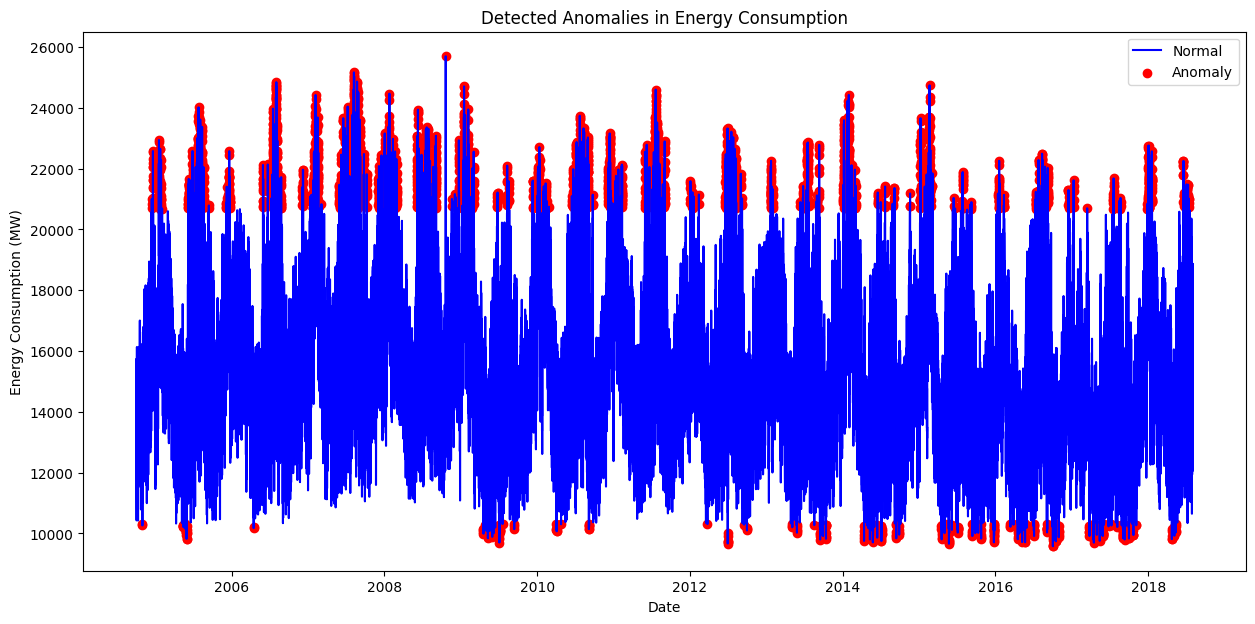

In [20]:
# Plot the normal data points
plt.figure(figsize=(15,7))
plt.plot(df_aep.index, df_aep['AEP_MW'], 'b-', label='Normal')

# Overlay the anomalies on the same plot with a different color
plt.scatter(df_aep.index[df_aep['is_anomaly']], df_aep['AEP_MW'][df_aep['is_anomaly']], color='r', label='Anomaly')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.title('Detected Anomalies in Energy Consumption')
plt.legend()

# Show the plot
plt.show()

# Step 6b: Anomaly Detection in LSTM Predictions
Anomaly detection is applied to the LSTM predictions by creating an 'is_anomaly' column, which flags data points that deviate significantly from the predicted mean, indicating potential anomalies.

In [21]:
# Calculate the mean and standard deviation of the 'normal' data
mean_value = predictions_df['LSTM Predictions'].mean()
std_dev = predictions_df['LSTM Predictions'].std()

# Define a function to apply to each row to determine if it's an anomaly
def detect_anomaly(value, mean, std, threshold=2):
    # Calculate how many standard deviations away value is from the mean
    z_score = (value - mean) / std
    if abs(z_score) > threshold:
        return True
    return False

# Apply the function to the 'LSTM Predictions' column to create a new 'is_anomaly' column
predictions_df['is_anomaly'] = predictions_df['LSTM Predictions'].apply(detect_anomaly, args=(mean_value, std_dev))

# Now, predictions_df will have an 'is_anomaly' column with True for anomalies and False for normal values

# Step 6c: Visualization of Anomalies in LSTM Predictions
Anomalies within the LSTM predictions are marked on the plot, contrasting the normal predicted values with those identified as outliers, providing a clear visual representation of deviations.

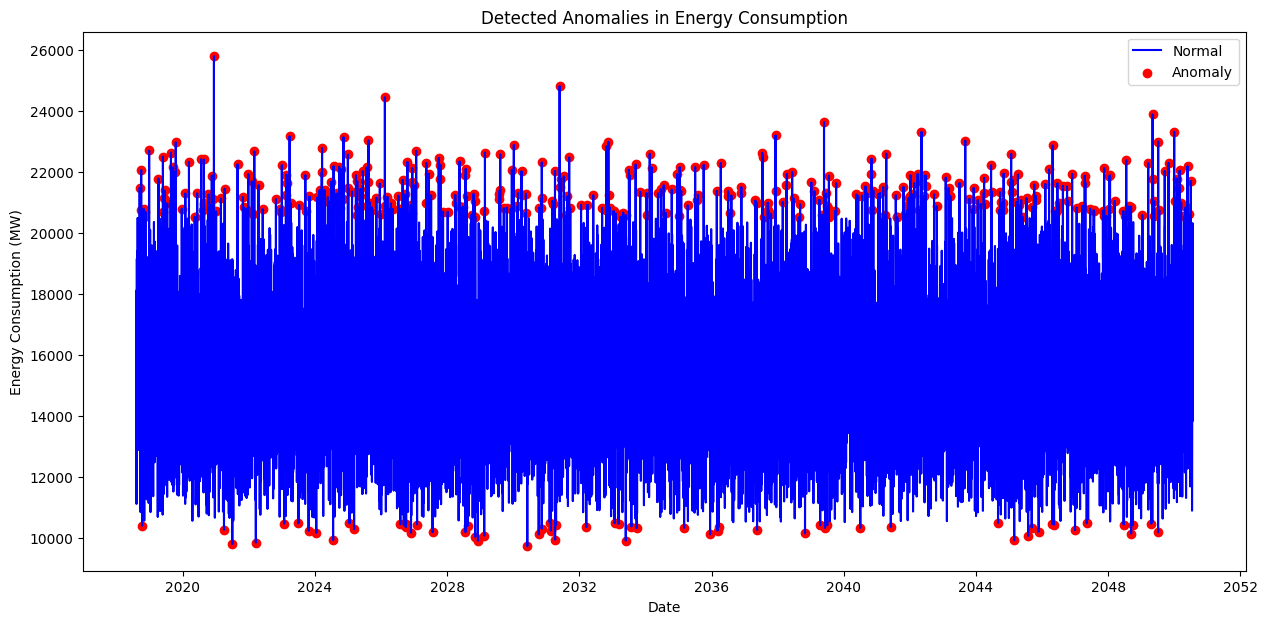

In [22]:
# Plot the normal data points
plt.figure(figsize=(15,7))
plt.plot(predictions_df.index, predictions_df['LSTM Predictions'], 'b-', label='Normal')

# Overlay the anomalies on the same plot with a different color
plt.scatter(predictions_df.index[predictions_df['is_anomaly']], predictions_df['LSTM Predictions'][predictions_df['is_anomaly']], color='r', label='Anomaly')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.title('Detected Anomalies in Energy Consumption')
plt.legend()

# Show the plot
plt.show()

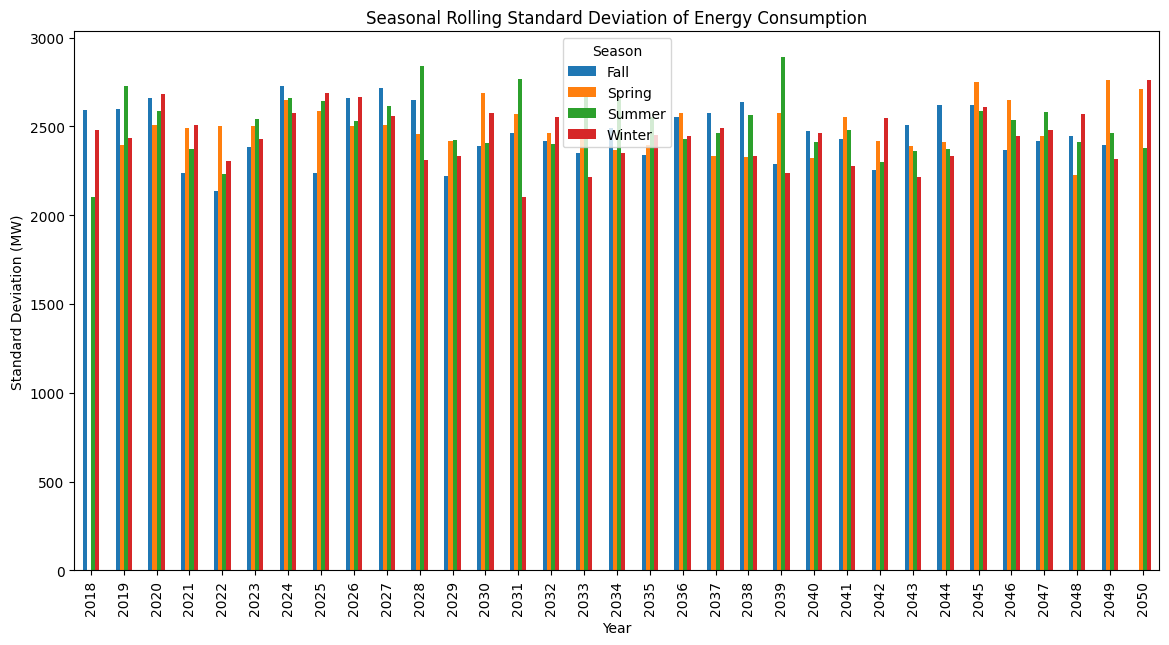

In [23]:
predictions_df.sort_index(inplace=True)
# Create a column for the year to facilitate resampling by seasons
predictions_df['Year'] = predictions_df.index.year

# Define the seasons
seasons = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
}

# Map the seasons to the index months
predictions_df['Season'] = predictions_df.index.month.map(seasons)

# Group by season and year, then calculate rolling standard deviation
predictions_df['Rolling_Std_Dev'] = predictions_df['LSTM Predictions'].rolling(window='30D').std()
seasonal_std_dev = predictions_df.groupby(['Year', 'Season'])['Rolling_Std_Dev'].mean().unstack()

# Plotting
seasonal_std_dev.plot(kind='bar', stacked=False, figsize=(14, 7))
plt.title('Seasonal Rolling Standard Deviation of Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Standard Deviation (MW)')
plt.show()

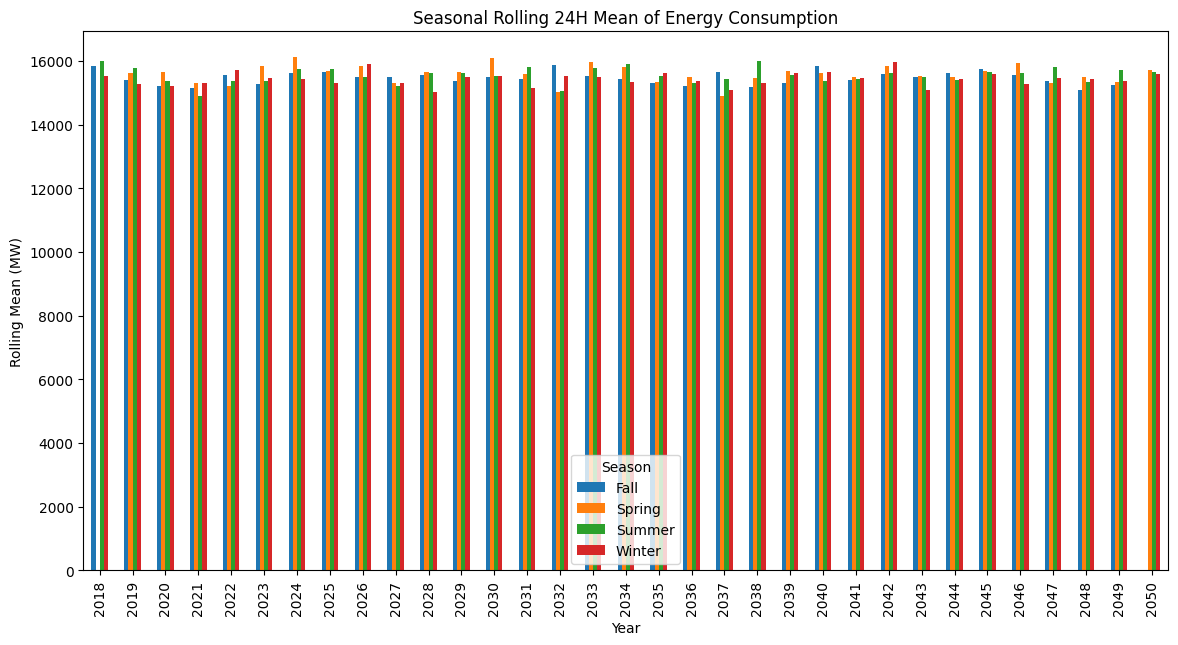

In [24]:
predictions_df['rolling_mean'] = predictions_df['LSTM Predictions'].rolling(window=window_size).mean()
predictions_df['rolling_sum'] = predictions_df['LSTM Predictions'].rolling(window=window_size).sum()
predictions_df['rolling_std'] = predictions_df['LSTM Predictions'].rolling(window=window_size).std()

seasonal_roll_mean = predictions_df.groupby(['Year', 'Season'])['rolling_mean'].mean().unstack()

# Plotting
seasonal_roll_mean.plot(kind='bar', stacked=False, figsize=(14, 7))
plt.title('Seasonal Rolling 24H Mean of Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Rolling Mean (MW)')
plt.show()